# Master code

#### Setup environment

#### Folder structure
```
.
├── data
│   ├── cell_feature
│   │   ├── eosin
│   │   ├── hema         (store cell feature)
│   │   └── rgb
│   ├── centroid         (store centroid location)
│   ├── graph_feature    (store graph conv feature + aggregate graph feature)
│   │   └── lap_matrix   (store laplacian matrix)
│   ├── img_arr          (store HE image array)
│   ├── mask             (store mask generated by RCNN)
│   ├── models           (store graph conv + random forest model
│   ├── results          (classification result)
│   └── tiles_rois
│       ├── normalized
│       └── original
└── mrcnn

```

#### Structure of the pipeline
1. Basic feature generation
    1. Mask generation
    2. Hema image generation
    3. Centroid generation
2. Feature generation
    1. Pyradiomic cell feature
    2. Histogram aggregation of cell feature
    3. Furthest point sampling graph feature
3. Feature Selection
    1. Mix feature ranking
    2. Cell feature ranking for graph convolution
4. Classification
    1. Random forest classifcation
        - train
        - predict
        - k-fold test
    2. Graph convolution classification
        - train
        - predict
        - k-fold test
    3. Average the result
5. Ablation study

## 1. Basic feature generation
### A. Mask generation

In [215]:
from pathlib import Path
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
import nucleus
import tensorflow as tf # 1.14.0
import os
import skimage
import pandas as pd
import numba
import keras # 2.1.0
import numpy as np
import requests
from tqdm.notebook import trange, tqdm
#conda install -c conda-forge ipywidgets
#jupyter nbextension enable --py widgetsnbextension


/home/minh/Desktop/Class/PathologyCancerClassification/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/minh/Desktop/Class/PathologyCancerClassification/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/minh/Desktop/Class/PathologyCancerClassification/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([

In [7]:
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                
model_weight_path = str(Path('./mask_rcnn_weights.h5').resolve())
if not os.path.exists(model_weight_path):
    download_file_from_google_drive('1pvySgKD53NLpDHtAJvoaj26SZWFIYIYR', Path('./mask_rcnn_weights.h5'))

In [4]:
config = nucleus.NucleusInferenceConfig()
config.display()
device = "/cpu:0"

model = None
with tf.device(device):
    model = modellib.MaskRCNN(mode="inference", model_dir=os.getcwd(), config=config)
    
model.load_weights(model_weight_path, by_name=True)


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

In [5]:
def gen_nuclear_masks_from_tile(
        nmodel: modellib.MaskRCNN,
        tile_file: str,
    ) -> pd.DataFrame:
    """ Runs MaskRCNN model on tile, returns data frame of true mask coordinates
    
    Arguments:
        nmodel {modellib.MaskRCNN} -- MaskRCNN model with weights loaded
        tile_file {str} -- path to tile image
    
    Returns:
        pd.DataFrame -- Data frame with tile_id, mask_id, and x,y coordinates of
            true values from mask
    """
    tile_id = tile_file.stem
    
    tile = skimage.io.imread(tile_file)
    scaled_tile = skimage.transform.rescale(tile, 2, multichannel=True) * 255
    patch_size = scaled_tile.shape[0]
    results = nmodel.detect([scaled_tile], verbose=0)
    r = results[0]
    individual_nuclei = r['masks']
    mask_dfs = []

    for i in range(individual_nuclei.shape[2]):
        descale_mask = skimage.transform.rescale(individual_nuclei[:,:,i], 0.5)
        y, x = np.where(descale_mask)
        y_mean, x_mean = np.mean((y, x), axis=1)
        mask_dict = {
            'tile': tile_id,
            'mask_id': i,
            'x': x,
            'y': y,
        }
        mask_dfs.append(pd.DataFrame.from_dict(mask_dict))

    return pd.concat(mask_dfs)

In [6]:
data_path = Path('./data') / 'train'
tiles_path = data_path / 'tiles_rois' /'original'
file_names = os.listdir(tiles_path)
output_path = data_path / 'output'
os.makedirs(output_path, exist_ok=True)

In [ ]:
mask_output_path = data_path / 'mask'
os.makedirs(mask_output_path, exist_ok=True)

for i in tqdm(range(len(file_names)), leave=False):
    masks = gen_nuclear_masks_from_tile(model, tiles_path / file_names[i])
    csv_name = file_names[i].split('.')[0] + '.csv'
    #masks.to_csv(mask_output_path / csv_name, index=False) 

### B. Hema image generation

In [9]:
import os
import numpy as np

from PIL import Image  
import histomicstk as htk


/home/minh/anaconda3/envs/BE223-final/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [12]:
## open image

def generate_he_image(image_path):
    im = Image.open(image_path)
    im_arr = np.array(im)
    # create stain to color map
    stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map
    
    # specify stains of input image
    stains = ['hematoxylin',  # nuclei stain
            'eosin',        # cytoplasm stain
            'null']         # set to null if input contains only two stains
    
    W = np.array([stain_color_map[st] for st in stains]).T
    
    imDeconvolved = htk.preprocessing.color_deconvolution.color_deconvolution(im_arr, W)
    
    deconvolved_image_h = imDeconvolved.Stains[:,:,0]
    deconvolved_image_e = imDeconvolved.Stains[:,:,1]
    
    return deconvolved_image_h, deconvolved_image_e, im_arr

sample_img = tiles_path / file_names[0]
h, e, rgb = generate_he_image(sample_img)
print(h.shape, e.shape, rgb.shape)

(512, 512) (512, 512) (512, 512, 3)


In [14]:
import h5py 
img_arr_dir = data_path/ 'img_arr'
os.makedirs(img_arr_dir, exist_ok=True)
with h5py.File(img_arr_dir / 'img_arr.h5', 'w') as file:
    for i in tqdm(range(len(file_names)), leave=False):
        h, e, rgb = generate_he_image(tiles_path / file_names[i])
        name = file_names[i].split('.')[0]
        file.create_dataset('{}/h'.format(name), data=h)
        file.create_dataset('{}/e'.format(name), data=e)
        file.create_dataset('{}/rgb'.format(name), data=rgb)

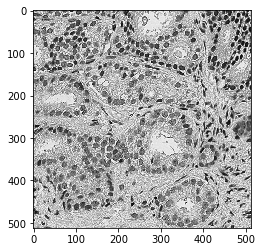

In [18]:
import matplotlib.pyplot as plt

with h5py.File(img_arr_dir / 'img_arr.h5', 'r') as file:
    arr = file['{}/h'.format(sample_img.stem.split('.')[0])]
    plt.imshow(arr, cmap='gray')


### C. Centroid generation

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import os
import h5py
from tqdm.notebook import trange, tqdm

def generate_centroid(mask_path):
    masks_csv = pd.read_csv(mask_path, header = 0)

    masks_csv.drop(columns = ['tile'], axis=1, inplace = True)
    mask_nums = masks_csv.mask_id.unique()
    mask_groups = masks_csv.groupby(['mask_id'])
    
    x = []
    y = []
    for mask in mask_nums:
        x.append(mask_groups.get_group(mask).x.mean())
        y.append(mask_groups.get_group(mask).y.mean())

    df = pd.DataFrame(columns=['x', 'y'])
    df['x'] = np.array(x)
    df['y'] = np.array(y)

In [ ]:
data_path = Path('./data') / 'train'
mask_dir = data_path / 'mask'
centroid_dir = data_path / 'centroid'
os.makedirs(centroid_dir, exist_ok=True)

mask_file_names = os.listdir(mask_dir)
for i in tqdm(range(len(mask_file_names)), leave=False):
    mask_path = mask_dir / mask_file_names[i]
    df = generate_centroid(mask_path, centroid_dir)
    df.to_csv(centroid_dir / '{}.csv'.format(mask_name), index=False)     

## 2. Feature generation
### A. Pyradiomic features

In [9]:
# tina
from pathlib import Path
from radiomics import glcm, imageoperations, shape, glrlm, glszm, getTestCase
from radiomics import featureextractor
import pandas as pd
import numpy as np
import SimpleITK as sitk
import os
import h5py
from tqdm.notebook import trange, tqdm
import radiomics
import logging

radiomics.logger.setLevel(logging.CRITICAL)

In [10]:
#=====================================
#Global error constants
SITKERROR = 999
MASKERROR = 990
SAVEERROR = 980
EXTRACTERROR = 970
CONCATERROR = 960
#======================================

#this function will reconstruct the mask with size of 512x512 from an array of coordinates [(r,c)]
#
def reconstruct_mask (coord, row=512, col = 512):
    #list of row coordinate, list of col coordinates
    coord = np.array(coord)
    rc = coord[:,0]
    cc = coord[:,1]

    mask = np.zeros((row,col))
    mask[rc,cc] = 1
    np.ma.make_mask(mask)
    return mask

In [11]:
def extract_features_from_mask_helper (img, mk):
#    image = sitk.ReadImage(imageName)
#    mask = sitk.ReadImage(maskName)
#    not sure whether this has to be sitk object
    image =  sitk.GetImageFromArray(img)
    try:
        image =  sitk.GetImageFromArray(img)
        mask = sitk.GetImageFromArray(mk)
    except:    
        #raise SitkError("Failed to convert array into Sitk Object")
        sys.exit(SITKERROR)

    #by default, it's 3d; so we need to change it
    extractor = featureextractor.RadiomicsFeatureExtractor(force2D = True)
    
    # Enables all feature classes
    extractor.enableAllFeatures()  
    featureVector = extractor.execute(image, mask)
    
    #remove unnecessary parameter settings
    
    keys = list(featureVector.keys())
    for k in keys[:10]:
        del featureVector[k]
    return featureVector

def extract_features_from_masks (image, mask_path):
    
    #read in masks
    try:
        masks_csv = pd.read_csv(mask_path, header = 0)
    except:
        sys.exit(MASKERROR)

    masks_csv.drop(columns = ['tile'], axis=1, inplace = True)
    mask_nums = masks_csv.mask_id.unique()
    mask_groups = masks_csv.groupby(['mask_id'])
    
   
    #acc will accumulate all the mask information
    acc = pd.DataFrame() 
    dim_error = []
    other_error = []
    for mask in mask_nums:
        row = mask_groups.get_group(mask).x
        col = mask_groups.get_group(mask).y
        coord = list(zip(row,col))
        # print("coord: \n", coord)

        # reconstruct mask from coordinates 
        reconstructed_mask = reconstruct_mask(coord)

        # TASK -> READ THE IMAGE
        try:
            featureVector =  extract_features_from_mask_helper(image, reconstructed_mask)
       
            values = np.array(list(featureVector.values())).reshape((1,-1))
            header = featureVector.keys()
            
            #since some mask has 1D array, thus we need to neglect those 
            df1 = pd.DataFrame(values, index = [mask], columns = header)
            
            #accumulate the mask with previous one
            acc = pd.concat([acc,df1])
            
        except ValueError:
            dim_error.append(mask)
        except:
            other_error.append(mask)

    return acc

In [12]:
data_path = Path('./data') / 'train'
mask_dir = data_path / 'mask'
mask_file_names = os.listdir(mask_dir)
img_arr_path = data_path / 'img_arr' / 'img_arr.h5'

cell_feature_dir = data_path / 'cell_feature'
os.makedirs(cell_feature_dir, exist_ok = True)

hema_cell_feature_dir = cell_feature_dir / 'hema'
os.makedirs(hema_cell_feature_dir, exist_ok = True)

eosin_cell_feature_dir = cell_feature_dir / 'eosin'
os.makedirs(eosin_cell_feature_dir, exist_ok = True)

rgb_cell_feature_dir = cell_feature_dir / 'rgb'
os.makedirs(rgb_cell_feature_dir, exist_ok = True)

In [ ]:
img_types = ['h']
with h5py.File(img_arr_path, 'r') as file:
    for i in tqdm(range(len(mask_file_names)), leave=False):
        mask_path = mask_dir / mask_file_names[i]
        mask_name = mask_file_names[i].split('.')[0]
        for img_type in img_types:
            arr = file['{}/{}'.format(mask_name, img_type)]
            df = extract_features_from_masks(arr, mask_path)
            df.index.name = 'mask_num'
            
            if img_type == 'h':
                df.to_csv(hema_cell_feature_dir / mask_file_names[i])
            elif img_type == 'e':  
                df.to_csv(eosin_cell_feature_dir / mask_file_names[i])
            else:
                df.to_csv(rgb_cell_feature_dir / mask_file_names[i])

###  B. Histogram aggregation of pyradiomic features

In [7]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm.notebook import trange, tqdm


In [8]:
#this function checks if there's any missing value in the columns
#given matrix in pd data structure form.
def checkMissing (matrix):
    cols = tile.columns[matrix.isna().any()].tolist()
    
def mean_extract_helper(tile):
    #clean data by removing the object_type columns 
    tile = remove_categorical(tile)

    #run through all means
    mean_tile = pd.DataFrame(tile.mean(), columns =[file_name]).transpose()
    total_nuclei = tile.count()[0]
    mean_tile['nuclei_counts'] = total_nuclei
    return mean_tile
        
def extract_histogram_features_helper(file_name , tile):
    description=tile.describe(percentiles=[.05,0.50,0.95])
    #cell_count 
    cell_count = tile.index.nunique()
    
    #dropping unwanted features
    unwanted_labels = ['count']
                   
    description.drop(labels = unwanted_labels,axis = 0, inplace = True)

    #for each features, generate histogram features  
    description= description.unstack(level=-1).to_frame().transpose()
    description.set_axis([f"{x+'_'}{y}" for x, y in description.columns], axis=1, inplace=True)
    description.index = [file_name]
    description['cell_count'] = cell_count
    return description

def remove_categorical(tile):
    #remove the object_type columns
    types = tile.dtypes
    obj_types_bool = list(map(lambda col: np.object == types[col], tile.columns))
    result = list(tile.columns[obj_types_bool])

    #remove categorical features in the tile, and preserving the numerical only 
    tile.drop(columns = result, inplace = True)
    return tile

In [9]:
def features_aggregator(file_path):
    #read_data
    tile = pd.read_csv(file_path, index_col=0)
    
    #remove_categorical variables/ clean data
    tile = remove_categorical(tile)
    
    return extract_histogram_features_helper(file_path.stem.split('.')[0], tile)

In [11]:
data_path = Path('./data') / 'train'
cell_feature_dir = data_path / 'masks_features'
cell_feature_file_names = os.listdir(cell_feature_dir)
output_dir = data_path / 'cell_feature'
os.makedirs(output_dir, exist_ok=True)

acc = pd.DataFrame()

for i in tqdm(range(len(cell_feature_file_names)), leave=False):
    df = features_aggregator(cell_feature_dir / cell_feature_file_names[i])
    acc = pd.concat([acc, df])
    
acc.index.name = 'tile_name'
acc.to_csv(output_dir / 'cell_features_aggr.csv')

KeyboardInterrupt: 

### C. Furthest point sampling graph feature

In [12]:
from PIL import Image, ImageDraw
import numpy as np
from sklearn.neighbors import NearestNeighbors, radius_neighbors_graph
from pathlib import Path
import os
import pandas as pd
from tqdm.notebook import trange, tqdm
import time, sys
import matplotlib.pyplot as plt

In [13]:
## function to perform furthest sampling

def calculate_distance_point_to_sets(point, points):
    point_dub = np.empty(points.shape)
    point_dub[:, 0] = point[0]
    point_dub[:, 1] = point[1]
    diff = point_dub - points
    diff_square = np.multiply(diff, diff)
    diff_square_sum = diff_square[:, 0] + diff_square[:, 1]
    eucledian = np.sqrt(diff_square_sum)
    min_distance = np.min(eucledian)
    return min_distance

def find_furthest_points(s_points, d_points):
    distance_array = np.empty(len(s_points))
    for i in range(len(s_points)):
        distance_array[i] = calculate_distance_point_to_sets(s_points[i], d_points)
        
    return np.argmax(distance_array)
    
def furthest_point_sampling(points, count, img_shape, graph=False):
    sample_points = []
    temp_points = points.copy()
    if count <= 1:
        return None
    
    sample_points.append(temp_points[0])
    temp_points = np.delete(temp_points, 0, axis=0)
    
    excluded_points = []
    excluded_points.append([sample_points[0][0], sample_points[0][1]])
    excluded_points.append([0,0])
    excluded_points.append([img_shape[0], 0])
    excluded_points.append([0, img_shape[1]])
    excluded_points.append([img_shape[0], img_shape[1]])
    for i in range(count - 1):
        index = find_furthest_points(temp_points, np.array(excluded_points))
        sample_points.append(temp_points[index])
        excluded_points.append(temp_points[index])
        temp_points = np.delete(temp_points, index, axis=0)
    
    sample_points = np.array(sample_points)
    
    if graph:
        points = np.array(points)
        plt.scatter(points[:, 0], points[:, 1])
        plt.scatter(sample_points[:, 0], sample_points[:, 1])
        plt.show()
        plt.clf()
    return sample_points

In [14]:
def generate_cell_graph(points, radius_limit, connection_limit, img_size, graph=False):
    neigh = radius_neighbors_graph(points, radius_limit, metric='euclidean')
    cell_graph = neigh.toarray()
    vertices = []
    edges = []
    adj_matrix = np.zeros((len(points), len(points)))
    degree_matrix = np.zeros((len(points), len(points)))
    for i in range(len(points)):
        current_connection = cell_graph[i]
        connect_locs = np.argwhere(current_connection == 1).flatten()

        if len(connect_locs) > connection_limit:
            distance_array = np.array([np.linalg.norm(points[i] - points[x]) for x in connect_locs])
            sort_indices = np.argsort(distance_array)
            connect_locs = connect_locs[sort_indices]
            connect_locs = connect_locs[:connection_limit]

        vertices.append(points[i].tolist())
        edges.append(points[np.array(connect_locs)].tolist())
        
        degree_matrix[i, i] = len(connect_locs)
        for conn in connect_locs:
            adj_matrix[i, conn] = np.linalg.norm(points[i] - points[conn]) / float(radius_limit)
    
    laplacian_matrix = degree_matrix - adj_matrix
    
    if graph:   
        size=2
        blank = Image.new('RGBA', img_size, (0,0,0,0))
        d = ImageDraw.Draw(blank)
        for i in range(len(vertices)):
            d.ellipse([points[i][0] - size, points[i][1] - size,
                       points[i][0] + size, points[i][1] + size], fill=(255,0,0))
            
            start_point = vertices[i]
            end_points = edges[i]
            for j in range(len(end_points)):
                d.line([start_point[0], start_point[1],
                            end_points[j][0], end_points[j][1]],
                            fill=(0,255,0), width=2)
        blank.show()
        
    return vertices, edges, adj_matrix, laplacian_matrix

def calculate_graph_statistic(cell_graph):
    vertices = cell_graph[0]
    edges = cell_graph[1]
    
    num_vertices = len(vertices)
    total_connections = 0
    total_connection_length = 0
    non_connecting_nodes = 0
    for i in range(num_vertices):
        total_connections += len(edges[i])
        conn_length = [np.linalg.norm(np.array(vertices[i]) - np.array(y)) for y in edges[i]]
        if len(conn_length) > 0:
            for length in conn_length:
                total_connection_length += length
        else:
            non_connecting_nodes += 1
        
    avg_connections = total_connections / float(num_vertices)
    avg_connection_length = total_connection_length / float(total_connections)
    non_connecting_nodes_fraction = non_connecting_nodes / float(num_vertices)
    
    data = [num_vertices, total_connections, total_connection_length,
            avg_connections, avg_connection_length, non_connecting_nodes,
            non_connecting_nodes_fraction]
    
    return data

In [15]:
def generate_cell_graph_statistic(centroid_path, matrix_path):
    alpha_ratio = 0.35
    beta_ratio = 0.15
    img_size = [512, 512]
    radius_limit = 100.
    connection_limit = 8
    
    df = pd.read_csv(centroid_path)
    
    x = df['x'].values
    x = x[np.logical_not(np.isnan(x))]
    
    y = df['y'].values
    y = y[np.logical_not(np.isnan(y))]
    
    points = [[a, b] for a,b in zip(x, y)]
    
    num_points = len(points)
    alpha_num_sample_points = int(alpha_ratio * num_points)
    alpha_sample_points = furthest_point_sampling(points, alpha_num_sample_points, img_size, graph=False)
    
    beta_num_sample_points = int(beta_ratio * num_points)
    
    
    beta_sample_points_index = np.random.choice(alpha_num_sample_points, beta_num_sample_points, replace=False)  
    beta_sample_points = np.take(alpha_sample_points, beta_sample_points_index, axis=0)
    
    
    vertices, edges, adj_matrix, lap_matrix = generate_cell_graph(beta_sample_points, radius_limit, connection_limit, img_size, graph=False)
    np.savetxt(matrix_path / centroid_path.name, lap_matrix, delimiter=',')
    
    cell_graph = [vertices, edges]
    
    cols = ['num_vertices', 'total_connections', 'total_connection_length',
            'avg_connections', 'avg_connection_length', 'non_connecting_nodes',
            'non_connecting_nodes_fraction']
    data = calculate_graph_statistic(cell_graph)
    
    return data, cols

In [16]:
data_path = Path('./data') / 'train'
centroid_dir = data_path / 'centroid'
cellgraph_feature_dir = data_path / 'graph_feature'
os.makedirs(cellgraph_feature_dir, exist_ok=True)

lap_matrix_dir = cellgraph_feature_dir / 'lap_matrix'
os.makedirs(lap_matrix_dir, exist_ok=True)


centroid_names = os.listdir(centroid_dir)
features = []
feature_name = None
for i in tqdm(range(len(centroid_names)), leave=False):
    name = centroid_names[i].split('.')[0] 
    data, feature_name = generate_cell_graph_statistic(centroid_dir / centroid_names[i], lap_matrix_dir)
    features.append([name] + data)
    
features = np.array(features)

col_names = ['tile_name'] + feature_name
df = pd.DataFrame(columns=col_names)

for i in tqdm(range(0, len(col_names)), leave=False):
    df[col_names[i]] = features[:, i]
    
df.to_csv(cellgraph_feature_dir / 'graph_feature.csv', index=False)



## 3. Feature selection
### A. Mix feature selection

In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

In [4]:
def generate_train_test_dataset(features_df, selected_features=None):
    cols = features_df.columns.values
    feature_names = []
    
    if selected_features is None:
        for name in cols:
            if name == 'tile_name' or name == 'label':
                continue
            feature_names.append(name)
    else:
        feature_names = selected_features

    data = []

    for name in feature_names:
        arr = np.nan_to_num(features_df[name].values)
        data.append(arr)
        
    data = np.array(data)
    t_data = np.transpose(data)
    
    labels = df['label'].values
    X_train, X_test, y_train, y_test = train_test_split(t_data, labels, test_size=0.2, shuffle=True, stratify=labels)
    
    return X_train, X_test, y_train, y_test, feature_names

def evaluate_features_rf(features_df):
    X_train, X_test, y_train, y_test, feature_names = generate_train_test_dataset(features_df)
    
    rf = RandomForestClassifier(n_estimators = 10000, random_state = 35, verbose=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    imp_score = rf.feature_importances_
    
    y_pred = rf.predict(X_test)
    
    high_to_low_index = np.flip(np.argsort(imp_score))
    feature_names = np.array(feature_names)[high_to_low_index]
    imp_score = imp_score[high_to_low_index]
    feature_scores = [feature_names, imp_score]
    return feature_scores

In [5]:
data_path = Path('./data') / 'train'
cellgraph_feature_path = data_path / 'graph_feature' / 'graph_feature.csv'
aggr_cell_feature_path = data_path / 'cell_feature'/ 'cell_features_aggr.csv'
label_path =  data_path / 'tiles_rois' / 'dataset.csv'
mix_feature_ranking_path = data_path / 'graph_feature' /  'mix_feature_ranking.csv'
mix_feature_path = data_path / 'graph_feature'/ 'mix_feature.csv'

label_df = pd.read_csv(label_path, index_col='tile_name')
label_df = label_df.drop(columns=['slide_id'])

aggr_cell_feature_df = pd.read_csv(aggr_cell_feature_path, index_col='tile_name')
cell_graph_feature_df = pd.read_csv(cellgraph_feature_path, index_col='tile_name')

df = label_df.merge(cell_graph_feature_df, on='tile_name')
df = df.merge(aggr_cell_feature_df, on='tile_name')
df.to_csv(mix_feature_path)


sorted_features = evaluate_features_rf(df)
ranking_df = pd.DataFrame(columns=['name', 'coef'])
ranking_df['name'] = sorted_features[0]
ranking_df['coef'] = sorted_features[1]
ranking_df.to_csv(mix_feature_ranking_path, index=False)

### B. Cell features selection

In [227]:
import os
import pandas as pd
import numpy as np
import sys
from sklearn.metrics import precision_recall_fscore_support
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#declaring public functions
__all__ = ['get_logreg_coef']


""" 
index_label_aggregated_features takes in two inputs and it will combined both pd_object based on the tile_name so the labels will align. It will return the X(features) and y(labels) in the same index. It will also drop the original index(which is the 'tile_name' column). 
"""
def index_label_aggregated_features(pd_aggregated_features,pd_label):
    #join based on tile_name and then split it again so index of the labels matches the aggregated fxn
    agg_features_withLabel = pd_aggregated_features.join(pd_label, lsuffix='_caller', rsuffix='_other')

    #normalized to same index 
    X_original = pd.DataFrame(pd_aggregated_features.values, columns = pd_aggregated_features.columns)
    y_original = pd.DataFrame(agg_features_withLabel['label'].values, columns = ['label'])
    return (X_original, y_original)

def indicator_helper(x):
    if x >= 0:
        return 1
    elif x < 0:
        return -1
    else:
        return 0

def get_logreg_coef(aggr_path, label_path, save_dir):
    #read aggregated_features
    agg_features = pd.read_csv(aggr_path, index_col = 'tile_name')
    labels = pd.read_csv(label_path, index_col='tile_name')
    labels.drop(columns=['slide_id'],inplace = True)
    
  
    X_original, y_original = index_label_aggregated_features(agg_features, labels)
    
    y = y_original
    X = X_original
    min_max_scaler = preprocessing.MinMaxScaler()

    X = min_max_scaler.fit_transform(X)
    X_train, X_test ,y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
    y_train = (y_train.values).ravel()
    y_test = (y_test.values).ravel()
    
    #manually default to this
    clf = LogisticRegression(max_iter= 5000, verbose=1, n_jobs=-1)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
    
    #get_logistic_regression_coefficients
    abs_coef = list(map(lambda x: abs(x), clf.coef_.flatten()))
    indicator = list(map(lambda x: indicator_helper(x), clf.coef_.flatten()))
    
    #output that into the a csv file with feature importance rank from highest to lowest
    d = {'abs_coef': abs_coef, 'indicator': indicator}
    var_coef = pd.DataFrame(data = d, index = agg_features.columns)
    var_coef.sort_values(by=['abs_coef'], ascending = False, inplace = True)
    
    output_path = save_dir / 'feature_ranking.csv'
    var_coef.to_csv(output_path)
    print("Successfully outputted coefficients to: ", output_path)
    

In [229]:
data_path = Path('./data') / 'train'
label_path = data_path / 'tiles_rois' / 'dataset.csv'
aggr_path = data_path / 'cell_feature' / 'cell_features_aggr.csv'
save_dir = data_path / 'cell_feature'

get_logreg_coef(aggr_path, label_path, save_dir)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Successfully outputted coefficients to:  data/train/cell_feature/feature_ranking.csv


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


## 4. Classification
### A. Random forest classification

In [82]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pickle
import os
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

#### Training

In [83]:
def prepare_data(feature_df, feature_ranking_path, top_feature):
    rank_df = pd.read_csv(feature_ranking_path)
    top_feature_names = rank_df['name'][:top_feature]
    
    df = feature_df.filter(top_feature_names)
    X = df[top_feature_names].values
    
    return X

def train_rf_model(feature_df, feature_ranking_path, top_feature=15):
    X= prepare_data(feature_df, feature_ranking_path, top_feature)
    y = feature_df['label'].values
    rf = RandomForestRegressor(n_estimators = 200,
                                  max_depth=50,
                                  min_samples_leaf=4,
                                  min_samples_split=4,
                                  bootstrap=True,
                                  max_features=6,
                                  n_jobs=-1)
    rf.fit(X, y)
    return rf

In [15]:
data_path = Path('./data') / 'train'
mix_feature_ranking_path = data_path / 'graph_feature' /  'mix_feature_ranking.csv'
mix_feature_path = data_path / 'graph_feature'/ 'mix_feature.csv'

model_dir = data_path / 'models'
os.makedirs(model_dir, exist_ok=True)
save_path = model_dir / 'rf.pkl'

feature_df = pd.read_csv(mix_feature_path, index_col='tile_name')
rf = train_rf_model(feature_df, mix_feature_ranking_path, model_dir / 'rf.pkl')
pickle.dump(rf, open(save_path, 'wb'))


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

#### Predict

In [14]:
def predict_from_model(model, feature_df, feature_ranking_path, top_feature=15):
    X = prepare_data(feature_df, feature_ranking_path, top_feature)
    y_pred = model.predict(X)
    tile_name = feature_df.index.values
    return [y_pred, tile_name]

In [23]:
data_path = Path('./data') / 'train'
mix_feature_ranking_path = data_path / 'graph_feature' /  'mix_feature_ranking.csv'
mix_feature_path = data_path / 'graph_feature'/ 'mix_feature.csv'
model_dir = data_path / 'models'
model_path = model_dir / 'rf.pkl'

pred_results_dir = data_path / 'results'
os.makedirs(pred_results_dir, exist_ok=True)

feature_df = pd.read_csv(mix_feature_path, index_col='tile_name')
model = pickle.load(open(model_path, 'rb'))
predict_from_model(model, feature_df, mix_feature_ranking_path)

array([9.52912782e-01, 5.74373765e-01, 7.76785714e-03, 1.85031219e-01,
       8.86803932e-01, 7.05350746e-01, 2.48294886e-01, 9.14150072e-01,
       6.87500000e-03, 2.14547355e-01, 5.42589626e-01, 6.33175602e-01,
       7.32026931e-01, 5.43189547e-01, 8.53443321e-01, 7.22278048e-01,
       9.86325397e-01, 8.49316794e-02, 1.60091450e-01, 8.75855533e-02,
       8.73425505e-01, 7.52373335e-01, 4.72665751e-01, 7.96873127e-01,
       9.07543970e-01, 4.88510656e-02, 1.36580780e-01, 1.28624459e-01,
       2.88497468e-01, 9.54003066e-01, 8.42936841e-01, 6.87386072e-01,
       3.24040612e-01, 1.68194444e-02, 3.21488095e-02, 9.91875000e-01,
       2.65121517e-01, 9.59634921e-01, 9.49007479e-01, 3.87065657e-01,
       8.48080877e-01, 1.26179654e-02, 1.97675172e-01, 9.51766803e-01,
       5.85329976e-01, 6.27123335e-01, 9.91089744e-01, 7.84256480e-01,
       7.94026113e-01, 9.80489011e-01, 7.14464286e-02, 3.64132486e-01,
       3.79588301e-01, 0.00000000e+00, 8.41482864e-01, 7.49372024e-01,
      

#### K-fold test

In [190]:
def k_fold_test(feature_df, feature_ranking_path, fold=10, top_feature=15):
    X = prepare_data(feature_df, feature_ranking_path, top_feature)
    y = feature_df['label'].values
    
    y_pred_list = []
    y_test_list = []
    
    skf = StratifiedKFold(n_splits=fold, random_state=None, shuffle=True)
    for train_index, test_index in skf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        rf = RandomForestRegressor(n_estimators = 200,
                                  max_depth=50,
                                  min_samples_leaf=4,
                                  min_samples_split=4,
                                  bootstrap=True,
                                  max_features=6)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        y_pred_list.append(y_pred)
        y_test_list.append(y_test.astype(float))
        
    
    y_test_all = np.concatenate(y_test_list)
    y_pred_all = np.concatenate(y_pred_list)
            
    fpr, tpr, _ = roc_curve(y_test_all, y_pred_all)
    print('Auc:', auc(fpr, tpr))
    plt.plot(fpr, tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.plot([0, 1], [0, 1], color='r', linestyle='--')
    plt.show()
    plt.clf()

Auc: 0.8835599999999999


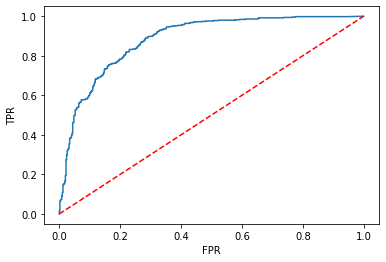

<Figure size 432x288 with 0 Axes>

In [192]:
data_path = Path('./data') / 'train'
mix_feature_ranking_path = data_path / 'graph_feature' /  'mix_feature_ranking.csv'
mix_feature_path = data_path / 'graph_feature'/ 'mix_feature.csv'

pred_results_dir = data_path / 'results'
os.makedirs(pred_results_dir, exist_ok=True)

feature_df = pd.read_csv(mix_feature_path, index_col='tile_name')
k_fold_test(feature_df, mix_feature_ranking_path, fold=10, top_feature=15)

### B. Graph Convolution Classification

In [1]:
""" Graph convuliton classification using pytorch geometric
Author: Samir Akre
"""

import pandas as pd
import torch
from torch_geometric.data import Data
from torch_geometric.nn import radius_graph
from typing import List
import ast
import os
from tqdm.notebook import tqdm
from pathlib import Path

import torch.nn.functional as F
import torch_geometric.nn as nn
from torch_geometric.nn import BatchNorm, SAGPooling, SAGEConv
from torch.nn import Linear

import skimage.io as io
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
import numpy as np
from torch_geometric.data import Data, DataLoader
import pickle
import importlib

from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import StratifiedKFold

#### Generate graph dataset

In [135]:
def create_data_set(
    node_feature_folder: str,
    tile_label_file_path: str,
    regression_coefficient_file: str,
    train = True,
    n_features: int = 64,
    max_neighbours: int = 8,
    radius: float = 50
) -> (List[Data], List[str]):
    """ Creates data set for input to model
    Arguments:
        node_feature_folder {str} -- Path to folder containing csv's of
            nuclear features files in folder expected to have file name
            "[tile_id].csv"
        tile_label_file_path {str} -- Path to csv labelling the 
            Cancer/no-cancer for tiles
        regression_coefficient_file {str} -- Path to file containing
            regression coefficients for feature selection
    Keyword Arguments:
        n_features {int} -- Number of node features to extract (default: {64})
        max_neighbours {int} --  max neighbors to use in graph generation
            (default: {8})
        radius {float} -- Max pixel radius for edge generation in graph
            construction (default: {50})
    Returns:
        List[Data] -- List pytorch input graphs, 1 item per tile
    """
    data_sets = []
    labels = pd.read_csv(tile_label_file_path)
    feature_files = os.listdir(node_feature_folder)
    feature_cols = None

    for feature_file_path in tqdm(feature_files, leave=False):
        tile_id = feature_file_path.split('.')[0]
        if train:
            label = labels[labels.tile_name == tile_id].label.values[0]
        else:
            label = -1

        feature_path = node_feature_folder / feature_file_path
        if feature_cols is None:
            feature_cols = select_node_feature_columns(
                feature_path,
                regression_coefficient_file,
                n_features,
            )
            
        data = gen_graph(
            feature_path,
            feature_cols,
            label,
            max_neighbours,
            radius,
        )
        data_sets.append([data, tile_id])

    return data_sets


def gen_graph(
    node_feature_path: str,
    node_feature_cols: List[str],
    label: int,
    max_neighbours: int = 8,
    radius: float = 50,
) -> Data:
    """ Generates graph from node features as pytorch object
    Arguments:
        node_feature_path {str} -- Path to node features for tile
        node_feature_cols {List[str]} -- list of features to use
        label {int} -- 1, or 0 for cancer/no-cancer
    Keyword Arguments:
        max_neighbours {int} -- k-max neighbors for graph edge (default: {8})
        radius {float} -- max pixel radius for graph edge (default: {50})
    Returns:
        Data object for use with pytorch geometric graph convolution
    """
    features = pd.read_csv(
        node_feature_path,
        converters={
            "diagnostics_Mask-original_CenterOfMass": ast.literal_eval
        }
    )

    # Normalize Features
    f_df = features[node_feature_cols]
    f_norm_df = (f_df - f_df.mean()) / (f_df.max() - f_df.min())
    f_norm_nafilled = f_norm_df.fillna(0)

    # Set centroid coordinates from node features
    coordinates = torch.tensor(
        features['diagnostics_Mask-original_CenterOfMass'].tolist()
    )

    # Set node features from normalized features
    node_features = torch.tensor(
        f_norm_nafilled.astype(float).values,
        dtype=torch.float32
    )

    # Initialize data for pytorch
    y = torch.tensor([label], dtype=torch.long)
    data = Data(
        x=node_features,
        pos=coordinates,
        y=y,
        num_classes=2
    )

    # Create Graph
    data.edge_index = radius_graph(
        data.pos,
        radius,
        None,
        True,
        max_neighbours
    )

    return data


def select_node_feature_columns(
        nuclear_feature_file: str,
        regression_coefficient_file: str,
        n: int
) -> List:
    """ Finds the top set of features from linear regression
    to use as nucleus features
    Arguments:
        nuclear_feature_file {str} -- Any nuclear feature file
            (Tina's csv output from pyradiomics)
        regression_coefficient_file {str} -- csv with tile level
            aggregated features ranked by coefficient in linear regression
        n {int} - Number of features
    Returns:
        List -- all features ranked by regression coefficients
    """
    features = pd.read_csv(nuclear_feature_file)
    feat_rank = pd.read_csv(regression_coefficient_file)
    feat_rank = feat_rank.rename(
        columns={feat_rank.columns[0]: 'feature'}
    )

    # Removes the 'aggregation' suffix
    feat_rank['base_feat'] = feat_rank['feature']\
        .str.split('_').str[:-1].str.join('_')

    # Find top features based on coefficient
    nuc_feat = pd.DataFrame(
        feat_rank.groupby('base_feat').abs_coef.max()
    ).reset_index()
    variable_cols = [
        col for col in features.columns
        if ('diagnostics_Image-original' not in col)
        and (col != 'diagnostics_Mask-original_VolumeNum')
    ]
    nuc_feat = nuc_feat[nuc_feat.base_feat.isin(variable_cols)]
    nuc_feat = nuc_feat.sort_values(by='abs_coef', ascending=False)
    
    return nuc_feat.base_feat.tolist()[:n]

In [44]:
data_path = Path('./data') /'train'
node_feature_dir = data_path / 'masks_features'
tile_label_path = data_path / 'tiles_rois' / 'dataset.csv'
coef_file = data_path / 'cell_feature' / 'feature_ranking.csv'
graph_dir = data_path / 'graph_feature'

dataset = create_data_set(node_feature_dir, tile_label_path, coef_file)
with open(graph_dir / 'graph_data.pkl', 'wb') as fp:
    pickle.dump(dataset, fp)

#### Graph convolution model

In [3]:
class Net(torch.nn.Module):
    def __init__(self, in_feats):
        super(Net, self).__init__()

        hs_1 = in_feats * 2
        self.conv1 = SAGEConv(in_feats, hs_1)
        self.bn1 = BatchNorm(hs_1)
        self.pool1 = SAGPooling(hs_1, ratio=0.5)

        hs_2 = int(hs_1 * 2)
        self.conv2 = SAGEConv(hs_1, hs_2)
        self.bn2 = BatchNorm(hs_2)
        self.pool2 = SAGPooling(hs_2, ratio=0.5)

        num_classes = 2
        self.lin1 = Linear(hs_2, num_classes).cuda()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x, edge_index, edge_attr, batch, perm, score = self.pool1(
          x, edge_index, batch=data.batch
        )

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x, edge_index, edge_attr, batch, perm, score = self.pool2(
          x, edge_index, batch=batch
        )

        x = nn.global_mean_pool(x, batch)
        x = F.relu(x)
        x = self.lin1(x)

        return F.softmax(x, dim=1)

#### Training

In [74]:
def train_graph_conv(dataset, save_path=None, epochs=500, batch_size=128, lr=0.0001, weight_decay=5e-4,
                     top_feature=64, device_type='cuda'):
    dataset = [x[0] for x in dataset]
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=False)
    device = torch.device(device_type)
    
    loss_function = torch.nn.CrossEntropyLoss()
    model = Net(top_feature).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    model.train()
    
    for epoch in tqdm(range(epochs), desc='epochs', leave=False):
        for batch in train_loader:
            data = batch.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = loss_function(out, data.y)
            loss.backward()
            optimizer.step()
            if torch.isnan(loss):
                break   
    
    if save_path is not None:
        torch.save(model.state_dict(), save_path)

    return model

In [45]:
data_path = Path('./data') / 'train'
graph_dir = data_path / 'graph_feature'
model_path = data_path / 'models' / 'graph_conv'
os.makedirs(model_path, exist_ok=True)

dataset = pickle.load(open(graph_dir / 'graph_data.pkl', 'rb'))


model= train_graph_conv(dataset, save_path=model_path / 'graph_conv.pth')


0 0
0 0
1 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 1
0 0
1 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 1
1 1
1 1
0 0
0 0
1 1
1 1
0 0
0 0
0 0
0 0
0 0
0 0
1 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 1
0 0
1 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 1
0 0
1 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 1
1 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 1
0 0
0 0
0 0
0 0
0 0
0 0
1 1
1 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 1
1 1
1 1
1 1
0 0
0 0
1 1
1 1
1 1
0 0
0 0
0 0
0 0
1 1
0 0
0 0
0 0
1 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 1
0 0
1 1
0 0
0 0
0 0
0 0
1 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 1
0 0
0 0
0 0
1 1
0 0
0 0
0 0
0 0
1 1
0 0
1 1
0 0
1 1
1 1
1 1
0 0
1 1
1 1
1 1
1 1
0 0
0 0
0 0
1 1
1 1
0 0
0 0
1 1
0 0
1 1


#### Predict

In [137]:
def predict_graph_conv(dataset_with_tile_name, model=None, model_path=None, top_feature=64, batch_size=1, device_type='cuda'):
    dataset = [x[0] for x in dataset_with_tile_name]
    tile_name = [x[1] for x in dataset_with_tile_name]
    test_loader = DataLoader(dataset, batch_size=batch_size, pin_memory=False)
    device = torch.device(device_type)
    
    if model_path is not None:
        model = Net(top_feature).to(device)
        model.load_state_dict(torch.load(model_path))
    model.eval()
    results = []
    index = 0
    for data in test_loader:
        data = data.to(device)
        results.append([model(data)[0][1].item(), tile_name[index]])
        index += 1
        
    return results

In [165]:
data_path = Path('./data') / 'test'
graph_dir = data_path / 'graph_feature'

dataset = pickle.load(open(graph_dir / 'graph_data.pkl', 'rb'))

model_path = data_path / 'models' / 'graph_conv' / 'graph_conv.pth'
result = predict_graph_conv(dataset, model_path=model_path)
print(result[:5])

[0.9998596906661987, 0.9965685606002808, 0.3127087950706482, 0.9997003078460693, 0.9931288957595825]


In [11]:
data_path = Path('./data') /'train'
graph_dir = data_path / 'graph_feature'

dataset = pickle.load(open(graph_dir / 'graph_data.pkl', 'rb'))
print(dataset[0].y.item())

1


#### K-fold test

In [195]:
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import StratifiedKFold

def k_fold_test_graph_conv(dataset, fold=10, epochs=500, batch_size=128, lr=0.0001, weight_decay=5e-4,
                     top_feature=64, device_type='cuda'):

    labels = [x[0].y.item() for x in dataset]
    y_pred = []
    y_true = []

    skf = StratifiedKFold(n_splits=fold, random_state=None, shuffle=True)
    
    for train_index, test_index in tqdm(skf.split(dataset,labels), total=fold, leave=False):
        X_train = [dataset[i] for i in train_index]
        X_test = [dataset[i] for i in test_index]
        
        y_test = [ x[0].y.item() for x in X_test]
        
        model = train_graph_conv(X_train, None, epochs, batch_size, lr, weight_decay,
                     top_feature, device_type)
        result = [x[0] for x in predict_graph_conv(X_test, model=model)]
        
        y_pred += result
        y_true += y_test
    
    y_true = np.array(y_true).astype(float)
    y_pred = np.array(y_pred).astype(float)
    target_names = ['no_cancer', 'cancer']

    fpr, tpr, _ = roc_curve(y_true, y_pred)
    print('Auc:', auc(fpr, tpr))
    plt.plot(fpr, tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.plot([0, 1], [0, 1], color='r', linestyle='--')
    plt.show()
    plt.clf()

In [ ]:
data_path = Path('./data') / 'train'
graph_dir = data_path / 'graph_feature'

dataset = pickle.load(open(graph_dir / 'graph_data.pkl', 'rb'))

k_fold_test_graph_conv(dataset)

In [ ]:
data_path = Path('./data') /'train'
graph_dir = data_path / 'graph_feature'

dataset = pickle.load(open(graph_dir / 'graph_data.pkl', 'rb'))

k_fold_test_graph_conv(dataset, epochs=1, batch_size=8)

Auc: 0.8106140000000001


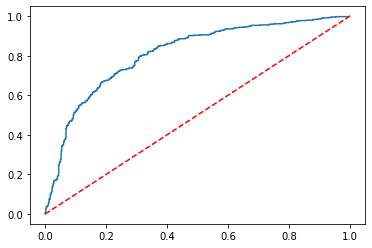

<Figure size 432x288 with 0 Axes>

In [76]:
data_path = Path('./data') / 'train'
graph_dir = data_path / 'graph_feature'

dataset = pickle.load(open(graph_dir / 'graph_data.pkl', 'rb'))

k_fold_test_graph_conv(dataset, epochs=100, batch_size=32)

Auc: 0.8010079999999999


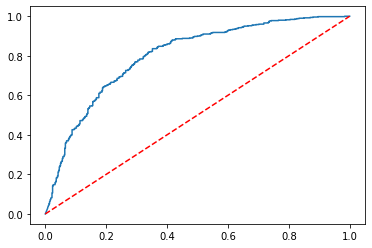

<Figure size 432x288 with 0 Axes>

In [77]:
data_path = Path('./data') / 'train'
graph_dir = data_path / 'graph_feature'

dataset = pickle.load(open(graph_dir / 'graph_data.pkl', 'rb'))

k_fold_test_graph_conv(dataset, epochs=200, batch_size=32)

Auc: 0.8028919999999999


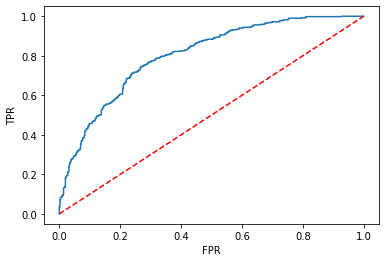

<Figure size 432x288 with 0 Axes>

In [197]:
data_path = Path('./data') / 'train'
graph_dir = data_path / 'graph_feature'

dataset = pickle.load(open(graph_dir / 'graph_data.pkl', 'rb'))

k_fold_test_graph_conv(dataset, epochs=50, batch_size=8)

Auc: 0.8212


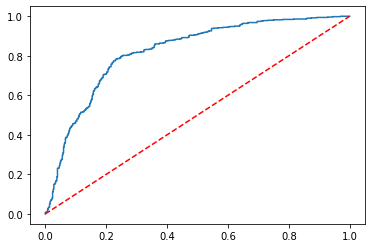

<Figure size 432x288 with 0 Axes>

In [80]:
data_path = Path('./data') / 'train'
graph_dir = data_path / 'graph_feature'

dataset = pickle.load(open(graph_dir / 'graph_data.pkl', 'rb'))

k_fold_test_graph_conv(dataset, epochs=100, batch_size=8)

Auc: 0.8271059999999999


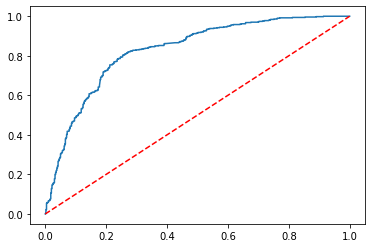

<Figure size 432x288 with 0 Axes>

In [79]:
data_path = Path('./data') / 'train'
graph_dir = data_path / 'graph_feature'

dataset = pickle.load(open(graph_dir / 'graph_data.pkl', 'rb'))

k_fold_test_graph_conv(dataset, epochs=50, batch_size=4)

Auc: 0.813484


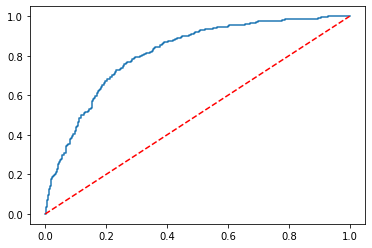

Auc: 0.616184


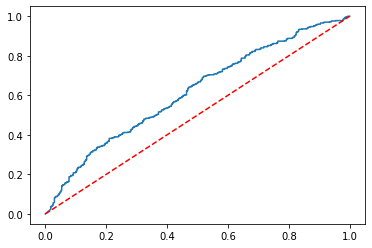

<Figure size 432x288 with 0 Axes>

In [81]:
data_path = Path('./data') / 'train'
graph_dir = data_path / 'graph_feature'

dataset = pickle.load(open(graph_dir / 'graph_data.pkl', 'rb'))

k_fold_test_graph_conv(dataset, epochs=50, batch_size=2)
k_fold_test_graph_conv(dataset, epochs=50, batch_size=1)

In [ ]:
def k_fold_test(feature_df, feature_ranking_path, fold=10, top_feature=15):
    X = prepare_data(feature_df, feature_ranking_path, top_feature)
    y = feature_df['label'].values
    
    y_pred_list = []
    y_test_list = []
    
    skf = StratifiedKFold(n_splits=fold, random_state=None, shuffle=True)
    for train_index, test_index in skf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        rf = RandomForestRegressor(n_estimators = 200,
                                  max_depth=50,
                                  min_samples_leaf=4,
                                  min_samples_split=4,
                                  bootstrap=True,
                                  max_features=6)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        y_pred_list.append(y_pred)
        y_test_list.append(y_test.astype(float))
        
    
    y_test_all = np.concatenate(y_test_list)
    y_pred_all = np.concatenate(y_pred_list)
            
    fpr, tpr, _ = roc_curve(y_test_all, y_pred_all)
    print('Auc:', auc(fpr, tpr))
    plt.plot(fpr, tpr, label='RF')
    plt.plot([0, 1], [0, 1], color='r', linestyle='--')
    plt.show()
    plt.clf()

def k_fold_test_graph_conv(dataset, fold=10, epochs=500, batch_size=128, lr=0.0001, weight_decay=5e-4,
                     top_feature=64, device_type='cuda'):

    labels = [x.y.item() for x in dataset]
    y_pred = []
    y_true = []

    skf = StratifiedKFold(n_splits=fold, random_state=None, shuffle=True)
    
    for train_index, test_index in tqdm(skf.split(dataset,labels), total=fold, leave=False):
        X_train = [dataset[i] for i in train_index]
        X_test = [dataset[i] for i in test_index]
        
        y_test = [ x.y.item() for x in X_test]
        
        model = train_graph_conv(X_train, None, epochs, batch_size, lr, weight_decay,
                     top_feature, device_type)
        result = predict_graph_conv(X_test, model=model)
        
        y_pred += result
        y_true += y_test
    
    y_true = np.array(y_true).astype(float)
    y_pred = np.array(y_pred).astype(float)
    target_names = ['no_cancer', 'cancer']

    fpr, tpr, _ = roc_curve(y_true, y_pred)
    print('Auc:', auc(fpr, tpr))
    plt.plot(fpr, tpr, label='RF')
    plt.plot([0, 1], [0, 1], color='r', linestyle='--')
    plt.show()
    plt.clf()


In [218]:
from operator import itemgetter

def prepare_data_average(feature_df, feature_ranking_path, dataset, top_feature=64):
    sort_dataset = sorted(dataset, key=itemgetter(1))
    sort_df = feature_df.sort_index()
    
    X_rf = prepare_data(sort_df, feature_ranking_path, top_feature)
    y_rf = sort_df['label'].values
    X_gcn = sort_dataset
    y_gcn = [x[0].y.item() for x in sort_dataset]
    
    return X_rf, y_rf, X_gcn, y_gcn


def k_fold_test_weight_avg(feature_df, feature_ranking_path, dataset, fold=10,
                           epochs=50, batch_size=128, lr=0.0001, weight_decay=5e-4,
                     top_feature=64, device_type='cuda'):

    X_rf, y_rf, X_gcn, y_gcn = prepare_data_average(feature_df, feature_ranking_path, dataset, top_feature)
    
    y_rf_pred = []
    y_gcn_pred = []
    y_true = []

    skf = StratifiedKFold(n_splits=fold, random_state=None, shuffle=True)
    
    for train_index, test_index in tqdm(skf.split(X_rf, y_rf), total=fold, leave=False):
        X_gcn_train = [X_gcn[i] for i in train_index]
        X_gcn_test = [X_gcn[i] for i in test_index]
        
        X_rf_train = X_rf[train_index]
        X_rf_test = X_rf[test_index]
        
        y_train = y_rf[train_index]
        y_test = y_rf[test_index]
        
        rf_model = RandomForestRegressor(n_estimators = 200,
                                  max_depth=50,
                                  min_samples_leaf=4,
                                  min_samples_split=4,
                                  bootstrap=True,
                                  max_features=6)
        rf_model.fit(X_rf_train, y_train)
        
        gcn_model = train_graph_conv(X_gcn_train, None, epochs, batch_size, lr, weight_decay,
                     top_feature, device_type)
        
        rf_result = rf_model.predict(X_rf_test)
        gcn_result = [x[0] for x in predict_graph_conv(X_gcn_test, model=gcn_model)]
        
        y_rf_pred += rf_result.tolist()
        y_gcn_pred += gcn_result
        y_true += y_test.tolist()
    
    y_true = np.array(y_true)
    y_rf_pred = np.array(y_rf_pred)
    y_gcn_pred = np.array(y_gcn_pred)

    target_names = ['no_cancer', 'cancer']

    rf_weight = np.arange(0.0, 1.01, 0.01)
    gcn_weight = 1 - rf_weight
    auc_results = []
    for i in range(len(rf_weight)):
        y_pred_temp = y_rf_pred * rf_weight[i] + y_gcn_pred * gcn_weight[i]
        fpr, tpr, _ = roc_curve(y_true, y_pred_temp)
        auc_results.append(auc(fpr, tpr))
    auc_results = np.array(auc_results)
    return rf_weight, gcn_weight, auc_results

In [219]:
data_path = Path('./data') / 'train'
graph_dir = data_path / 'graph_feature'

dataset = pickle.load(open(graph_dir / 'graph_data.pkl', 'rb'))

mix_feature_ranking_path = data_path / 'graph_feature' /  'mix_feature_ranking.csv'
mix_feature_path = data_path / 'graph_feature'/ 'mix_feature.csv'

pred_results_dir = data_path / 'results'
os.makedirs(pred_results_dir, exist_ok=True)

feature_df = pd.read_csv(mix_feature_path, index_col='tile_name')

rf_weights, gcn_weights, auc_results = k_fold_test_weight_avg(feature_df, mix_feature_ranking_path, dataset, fold=10,
                           epochs=50, batch_size=8, lr=0.0001, weight_decay=5e-4,
                     top_feature=64, device_type='cuda')

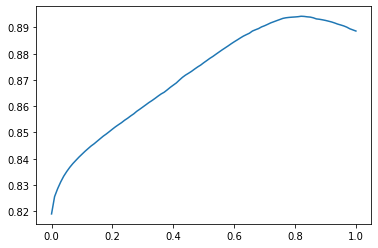

In [175]:
plt.plot(rf_weights, auc_results)

In [179]:
index = np.argmax(auc_results)
print(rf_weights[index], auc_results[index])

0.8200000000000001 0.894288


In [212]:
def k_fold_test_weight_avg(feature_df, feature_ranking_path, dataset, weights, fold=10,
                           epochs=50, batch_size=128, lr=0.0001, weight_decay=5e-4,
                     top_feature=64, device_type='cuda'):

    X_rf, y_rf, X_gcn, y_gcn = prepare_data_average(feature_df, feature_ranking_path, dataset, top_feature)
    
    y_rf_pred = []
    y_gcn_pred = []
    y_true = []
    y_pred = []
    skf = StratifiedKFold(n_splits=fold, random_state=None, shuffle=True)
    
    for train_index, test_index in tqdm(skf.split(X_rf, y_rf), total=fold, leave=False):
        X_gcn_train = [X_gcn[i] for i in train_index]
        X_gcn_test = [X_gcn[i] for i in test_index]
        
        X_rf_train = X_rf[train_index]
        X_rf_test = X_rf[test_index]
        
        y_train = y_rf[train_index]
        y_test = y_rf[test_index]
        
        rf_model = RandomForestRegressor(n_estimators = 200,
                                  max_depth=50,
                                  min_samples_leaf=4,
                                  min_samples_split=4,
                                  bootstrap=True,
                                  max_features=6)
        rf_model.fit(X_rf_train, y_train)
        
        gcn_model = train_graph_conv(X_gcn_train, None, epochs, batch_size, lr, weight_decay,
                     top_feature, device_type)
        
        rf_result = rf_model.predict(X_rf_test)
        gcn_result = [x[0] for x in predict_graph_conv(X_gcn_test, model=gcn_model)]
        
        y_rf_pred += rf_result.tolist()
        y_gcn_pred += gcn_result
        y_true += y_test.tolist()
        
    y_pred += (weights[0] * np.array(y_rf_pred) + weights[1] * np.array(y_gcn_pred)).tolist()
    y_true = np.array(y_true).astype(float)
    y_pred = np.array(y_pred).astype(float)
    
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    print('Auc:', auc(fpr, tpr))
    plt.plot(fpr, tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.plot([0, 1], [0, 1], color='r', linestyle='--')
    plt.show()


Auc: 0.89304


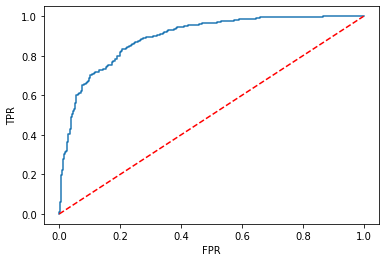

In [214]:
data_path = Path('./data') / 'train'
graph_dir = data_path / 'graph_feature'

dataset = pickle.load(open(graph_dir / 'graph_data.pkl', 'rb'))

mix_feature_ranking_path = data_path / 'graph_feature' /  'mix_feature_ranking.csv'
mix_feature_path = data_path / 'graph_feature'/ 'mix_feature.csv'

pred_results_dir = data_path / 'results'
os.makedirs(pred_results_dir, exist_ok=True)

feature_df = pd.read_csv(mix_feature_path, index_col='tile_name')

k_fold_test_weight_avg2(feature_df, mix_feature_ranking_path, dataset, [0.82, 0.18], fold=10,
                           epochs=50, batch_size=8, lr=0.0001, weight_decay=5e-4,
                     top_feature=64, device_type='cuda')

## 5. Ablation study on train data (not really useful after seeing the test result)

#### 5.1 Random forest

In [84]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pickle
import os
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc

In [85]:
def prepare_data(feature_df, feature_ranking_path, top_feature):
    rank_df = pd.read_csv(feature_ranking_path)
    top_feature_names = rank_df['name'][:top_feature]
    
    df = feature_df.filter(top_feature_names)
    X = df[top_feature_names].values
    
    return X

def ablation_k_fold_test(feature_df, feature_ranking_path, save_path, fold=10, top_feature=15):
    X = prepare_data(feature_df, feature_ranking_path, top_feature)
    y = feature_df['label'].values
    
    
    train_percent = np.arange(0.05, 0.95,0.05)
    test_percent = 1 - train_percent    
    auc_results = []
    
    for i in tqdm(range(len(train_percent)), leave=False):
        
        y_pred_list = []
        y_test_list = []



        skf = StratifiedShuffleSplit(n_splits=fold, test_size=test_percent[i], train_size=train_percent[i])
        for train_index, test_index in skf.split(X,y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            rf = RandomForestRegressor(n_estimators = 200,
                                      max_depth=50,
                                      min_samples_leaf=4,
                                      min_samples_split=4,
                                      bootstrap=True,
                                      max_features=6,
                                      n_jobs=-1)
            rf.fit(X_train, y_train)
            y_pred = rf.predict(X_test)
            y_pred_list.append(y_pred)
            y_test_list.append(y_test.astype(float))
        
    
        y_test_all = np.concatenate(y_test_list)
        y_pred_all = np.concatenate(y_pred_list)

        fpr, tpr, _ = roc_curve(y_test_all, y_pred_all)
        auc_results.append(auc(fpr, tpr))
    
    df = pd.DataFrame(columns=['train_percent', 'auc'])
    df['train_percent'] = train_percent
    df['auc'] = np.array(auc_results)
    df.to_csv(save_path, index=False)
    
    plt.plot(train_percent, auc_results)
    plt.xlabel('Train portion')
    plt.ylabel('AUC')
    plt.show()
    plt.clf()

In [95]:

def ablation_k_fold_train(feature_df, feature_ranking_path, top_feature=15):
    X = prepare_data(feature_df, feature_ranking_path, top_feature)
    y = feature_df['label'].values
    
    
    train_percent = np.arange(0.05, 1.05,0.05)
    models = []
    
    for i in tqdm(range(len(train_percent)-1), leave=False):
       
        skf = StratifiedShuffleSplit(n_splits=1, test_size=None, train_size=train_percent[i])
        for train_index, test_index in skf.split(X,y):
            X_train = X[train_index]
            y_train = y[train_index]

            rf = RandomForestRegressor(n_estimators = 200,
                                      max_depth=50,
                                      min_samples_leaf=4,
                                      min_samples_split=4,
                                      bootstrap=True,
                                      max_features=6,
                                      n_jobs=-1)
            rf.fit(X_train, y_train)
            models.append(rf)
            
    rf = RandomForestRegressor(n_estimators = 200,
                                      max_depth=50,
                                      min_samples_leaf=4,
                                      min_samples_split=4,
                                      bootstrap=True,
                                      max_features=6,
                                      n_jobs=-1)
    rf.fit(X, y)
    models.append(rf)
    
    return models, train_percent

In [98]:
data_path = Path('./data')/'train'
mix_feature_ranking_path = data_path / 'graph_feature' /  'mix_feature_ranking.csv'
mix_feature_path = data_path / 'graph_feature'/ 'mix_feature.csv'

model_dir = Path('./data') / 'models' / 'rf'
os.makedirs(model_dir, exist_ok = True)

feature_df = pd.read_csv(mix_feature_path, index_col='tile_name')
models, train_percent = ablation_k_fold_train(feature_df, mix_feature_ranking_path, top_feature=15)
for model, tp in zip(models, train_percent):
    with open(model_dir /'rf_{:.2f}.pkl'.format(tp), 'wb') as f:
        pickle.dump(model, f)

In [124]:
data_path = Path('./data') / 'test'
train_path = Path('./data') / 'train'
mix_feature_ranking_path = train_path / 'graph_feature' /  'mix_feature_ranking.csv'
mix_feature_path = data_path / 'graph_feature'/ 'mix_feature.csv'
model_dir = Path('./data') / 'models' / 'rf'
models_name = os.listdir(model_dir)
models_name.sort()

cellgraph_feature_path = data_path / 'graph_feature' / 'graph_feature.csv'
aggr_cell_feature_path = data_path / 'cell_feature'/ 'cell_features_aggr.csv'
label_path =  data_path / 'tiles_rois' / 'dataset_class.csv'

label_df = pd.read_csv(label_path, index_col='tile_name')
label_df = label_df.drop(columns=['slide_id'])

aggr_cell_feature_df = pd.read_csv(aggr_cell_feature_path, index_col='tile_name')
cell_graph_feature_df = pd.read_csv(cellgraph_feature_path, index_col='tile_name')

df = label_df.merge(cell_graph_feature_df, on='tile_name')
df = df.merge(aggr_cell_feature_df, on='tile_name')
df.to_csv(mix_feature_path)

pred_results_dir = Path('./data') / 'results'
os.makedirs(pred_results_dir, exist_ok=True)
results = []

feature_df = pd.read_csv(mix_feature_path, index_col='tile_name')
for i in tqdm(range(len(models_name)), leave=False):
    model = pickle.load(open(model_dir / models_name[i], 'rb'))
    result = predict_from_model(model, feature_df, mix_feature_ranking_path)
    results.append(result)

df = pd.DataFrame()
df['tile_name'] = feature_df.index.values
for i in tqdm(range(len(models_name)), leave=False):
    model_name = models_name[i][:-4]
    df[model_name] = np.array(results[i])
df.to_csv(pred_results_dir / 'rf_ablation_results.csv', index=False)

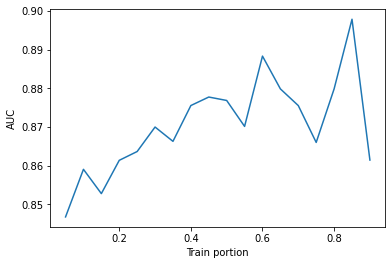

<Figure size 432x288 with 0 Axes>

In [214]:
data_path = Path('./data')/'train'
mix_feature_ranking_path = data_path / 'graph_feature' /  'mix_feature_ranking.csv'
mix_feature_path = data_path / 'graph_feature'/ 'mix_feature.csv'

pred_results_dir = data_path / 'results'
os.makedirs(pred_results_dir, exist_ok=True)


feature_df = pd.read_csv(mix_feature_path, index_col='tile_name')
ablation_k_fold_test(feature_df, mix_feature_ranking_path, pred_results_dir  / 'k_fold_test.csv',
                     fold=10, top_feature=15)

In [ ]:
data_path = Path('./data')
mix_feature_ranking_path = data_path / 'graph_feature' /  'mix_feature_ranking.csv'
mix_feature_path = data_path / 'graph_feature'/ 'mix_feature.csv'

model_dir = data_path / 'models'
os.makedirs(model_dir, exist_ok=True)
save_path = model_dir / 'rf.pkl'

feature_df = pd.read_csv(mix_feature_path, index_col='tile_name')
rf = train_rf_model(feature_df, mix_feature_ranking_path, model_dir / 'rf.pkl')
pickle.dump(rf, open(save_path, 'wb'))


#### 5.2 Graph conv

In [99]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pickle
import os
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc

In [100]:
import pandas as pd
import torch
from torch_geometric.data import Data
from torch_geometric.nn import radius_graph
from typing import List
import ast
import os
from tqdm.notebook import tqdm
from pathlib import Path

import torch.nn.functional as F
import torch_geometric.nn as nn
from torch_geometric.nn import BatchNorm, SAGPooling, SAGEConv
from torch.nn import Linear

import skimage.io as io
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
import numpy as np
from torch_geometric.data import Data, DataLoader
import pickle
import importlib

from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import StratifiedKFold

In [101]:
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import StratifiedKFold

def albation_test_graph_conv(dataset, save_path, fold=10, epochs=1000, batch_size=128, lr=0.0001, weight_decay=5e-4,
                     top_feature=64, device_type='cuda'):

    labels = [x.y.item() for x in dataset]
    
    train_percent = np.arange(0.05, 0.95,0.05)
    test_percent = 1 - train_percent    
    auc_results = []

    for i in tqdm(range(len(train_percent)),desc='train_percent'):

        y_pred = []
        y_true = []
        
        skf = StratifiedShuffleSplit(n_splits=fold, test_size=test_percent[i], train_size=train_percent[i])
        for train_index, test_index in tqdm(skf.split(dataset,labels), total=fold, desc='fold'):
            X_train = [dataset[i] for i in train_index]
            X_test = [dataset[i] for i in test_index]

            y_test = [ x.y.item() for x in X_test]

            model = train_graph_conv(X_train, None, epochs, batch_size, lr, weight_decay,
                         top_feature, device_type)
            result = predict_graph_conv(X_test, model=model)

            y_pred += result
            y_true += y_test


        y_true = np.array(y_true).astype(float)
        y_pred = np.array(y_pred).astype(float)
        target_names = ['no_cancer', 'cancer']

        fpr, tpr, _ = roc_curve(y_true, y_pred)
        auc_results.append(auc(fpr, tpr))
    
    df = pd.DataFrame(columns=['train_percent', 'auc'])
    df['train_percent'] = train_percent
    df['auc'] = np.array(auc_results)
    df.to_csv(save_path, index=False)
    
    plt.plot(train_percent, auc_results)
    plt.xlabel('Train portion')
    plt.ylabel('AUC')
    plt.show()
    plt.clf()

In [127]:
def albation_train_graph_conv(dataset, save_dir, suffix, epochs=50, batch_size=8, lr=0.0001, weight_decay=5e-4,
                     top_feature=64, device_type='cuda'):

    labels = [x[0].y.item() for x in dataset]
    models = []
    train_percent = np.arange(0.05, 1.05,0.05)
    for i in tqdm(range(len(train_percent) - 1),desc='train_percent', leave=False):

        skf = StratifiedShuffleSplit(n_splits=1, test_size=None, train_size=train_percent[i])
        for train_index, test_index in tqdm(skf.split(dataset,labels), total=1, desc='fold', leave=False):
            X_train = [dataset[i] for i in train_index]
            y_train = [ x[0].y.item() for x in X_train]

            model = train_graph_conv(X_train, save_dir / '{}_{:.2f}.pth'.format(suffix, train_percent[i]), 
                                     epochs, batch_size, lr, weight_decay,
                         top_feature, device_type)
            models.append(model)
            
    model = train_graph_conv(X_train, save_dir / '{}_{:.2f}.pth'.format(suffix, train_percent[-1]),
                                epochs, batch_size, lr, weight_decay,
                                top_feature, device_type)
    models.append(model)
    return models, train_percent



In [129]:
data_path = Path('./data') / 'train'
graph_dir = data_path / 'graph_feature'
model_dir = Path('./data') / 'models' / 'graph_conv'
os.makedirs(model_dir, exist_ok=True)

dataset = pickle.load(open(graph_dir / 'graph_data.pkl', 'rb'))

models, train_percent = albation_train_graph_conv(dataset, model_dir, suffix = 'graph_conv')

In [143]:
data_path = Path('./data') / 'test'
graph_dir = data_path / 'graph_feature'
model_dir = Path('./data') / 'models' / 'graph_conv'
models_name = os.listdir(model_dir)
models_name.sort()

train_path = Path('./data') /'train'
node_feature_dir = data_path / 'cell_feature' / 'hema'
tile_label_path = data_path / 'tiles_rois' / 'dataset_class.csv'
coef_file = train_path / 'cell_feature' / 'feature_ranking.csv'
graph_dir = data_path / 'graph_feature'

dataset = create_data_set(node_feature_dir, tile_label_path, coef_file, train=False)
with open(graph_dir / 'graph_data.pkl', 'wb') as fp:
    pickle.dump(dataset, fp)

dataset = pickle.load(open(graph_dir / 'graph_data.pkl', 'rb'))
results = []

tile_name = None
for i in tqdm(range(len(models_name)), leave=False):
    model_path = model_dir / models_name[i]
    result = predict_graph_conv(dataset, model_path=model_path)
    sort_result = sorted(result, key=lambda x: x[1])
    if tile_name is None:
        tile_name= [x[1] for x in sort_result]
    result = [x[0] for x in sort_result]
    results.append(result)
results = np.array(results)

In [144]:
result_dir = Path('./data') / 'results'

df = pd.DataFrame()
df['tile_name'] = tile_name

for result, model_name in zip(results, models_name):
    name = model_name[:-4]
    df[name] = result
df.to_csv(result_dir / 'graph_conv_ablation_results.csv', index=False)

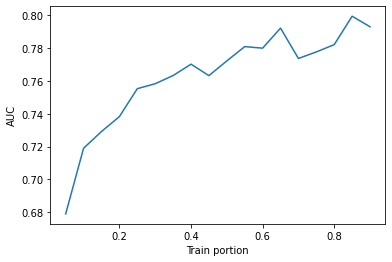

<Figure size 432x288 with 0 Axes>

In [225]:
data_path = Path('./data') / 'train'
graph_dir = data_path / 'graph_feature'
model_path = data_path / 'models' / 'graph_conv'
os.makedirs(model_path, exist_ok=True)
save_path = model_path = data_path / 'models' / 'graph_conv' / 'results.csv'
dataset = pickle.load(open(graph_dir / 'graph_data.pkl', 'rb'))

albation_test_graph_conv(dataset, save_path)

In [ ]:
data_path = Path('./data') / 'train'
graph_dir = data_path / 'graph_feature'
model_path = data_path / 'models' / 'graph_conv'
os.makedirs(model_path, exist_ok=True)
save_path = model_path = data_path / 'models' / 'graph_conv' / 'results.csv'
dataset = pickle.load(open(graph_dir / 'graph_data.pkl', 'rb'))

albation_test_graph_conv2(dataset, save_path)

#### Weight_average

In [183]:
result_dir = Path('./data') / 'results' / 'test'

conv_df = pd.read_csv(result_dir / 'graph_conv_ablation_results.csv', index_col=0)
rf_df = pd.read_csv(result_dir / 'rf_ablation_results.csv', index_col=0)

conv_cols = conv_df.columns.values
rf_cols = rf_df.columns.values
print(conv_cols[:5])
print(rf_cols[:5])

['graph_conv_0.05' 'graph_conv_0.10' 'graph_conv_0.15' 'graph_conv_0.20'
 'graph_conv_0.25']
['rf_0.05' 'rf_0.10' 'rf_0.15' 'rf_0.20' 'rf_0.25']


In [188]:
rf_weight = 0.82
gcn_weight = 0.18

train_percent = np.arange(0.05, 1.05, 0.05)
merge_df = conv_df.merge(rf_df, on='tile_name')
merge_df.head()

,graph_conv_0.05,graph_conv_0.10,graph_conv_0.15,graph_conv_0.20,graph_conv_0.25,graph_conv_0.30,graph_conv_0.35,graph_conv_0.40,graph_conv_0.45,graph_conv_0.50,...,rf_0.55,rf_0.60,rf_0.65,rf_0.70,rf_0.75,rf_0.80,rf_0.85,rf_0.90,rf_0.95,rf_1.00
tile_name,,,,,,,,,,,,,,,,,,,,,
1000_98560_20608,0.792882,0.322053,0.712704,0.042766,0.022925,0.346067,6.596689e-01,1.123455e-01,0.352565,0.006216,...,0.498006,0.706005,0.749637,0.766366,0.696153,0.670527,0.605196,0.656719,0.763338,0.711973
1009_81536_17024,0.813531,0.473425,0.813570,0.990532,0.922463,0.390169,9.884300e-01,1.898852e-01,0.073058,0.840376,...,0.608386,0.703001,0.399433,0.560170,0.580072,0.591536,0.559564,0.544041,0.610743,0.604599
1011_38528_7168,0.994008,0.585066,0.991869,0.847329,0.999624,0.929312,9.965035e-01,4.258155e-02,0.945375,0.991623,...,0.715653,0.767559,0.795556,0.795234,0.804485,0.789811,0.849776,0.748400,0.822434,0.806335
1035_27328_7616,0.065564,0.621944,0.772818,0.000002,0.013180,0.000301,5.102438e-08,7.641148e-07,0.000015,0.000008,...,0.113478,0.094389,0.165795,0.117487,0.085492,0.121239,0.107960,0.083776,0.111373,0.109075
1037_45248_4928,0.659601,0.914818,0.877715,0.330698,0.992522,0.473763,8.964229e-02,5.772746e-01,0.780620,0.147118,...,0.560668,0.592934,0.488714,0.541553,0.587265,0.574761,0.501650,0.613242,0.615541,0.578730


In [189]:
df = pd.DataFrame()
df['tile_name'] = merge_df.index.values
for i in range(len(train_percent)):
    name = 'weight_avg_{:.2f}'.format(train_percent[i])
    df[name] = rf_weight * merge_df[rf_cols[i]].values + gcn_weight * merge_df[conv_cols[i]].values
df.to_csv(result_dir / 'weight_average_ablation_results.csv', index=False) 